# Project01 Part 2

## 1 Bandits

### 1.1 Formalizing the problem as a multi-armed bandits problem

GOAL: Maximize the number of flyers given out at one street corner, over some number of days for which the problem will take place.

I want my model to encapture exploration and exploitation. In context of the problem, I want my model to be able to explore the best intersection and give out the most flyers possible. 

The arms will be the intersections from the candidate list of intersections. The action A, "pulling an arm", will represent going to the intersection and giving out flyers under the uniform probability distribution P. The reward R will be how many flyers are handed out and will be modeled as bounded random variable from [0, R].

The time horizon will be from 10am-2pm, 4 hours total. I chose this time horizon because I believe the time of the day fully encaptures the pedestrians getting a lunch meal.

Assumptions: The model process will have N=1000 trials.
The errors in the model is assumed to be random and follow the normal distribution.
The recruiter will not know the probability of the reward from each intersection.
The number of trials must be greater than the number of intersections K (N>K).
The samples must be generated randomly. 
The intersections are independent from each other, meaning no intersection will effect the rewards of the other.

I expect the statistical model to hold the number of N trials, but it will eventually learn the probabilities, so that initial assumption will not hold. 
This way, the recruiter will be able to exploit the best intersection. 
For the number of trials greater than the number of intersections, I expect that to hold because otherwise, the recruiter will not be able to explore all possible intersections.
The random assumption should still hold because if not, the model would not follow the statistical process, as well as the independency assumption. 
Gathering more data will allow the model errors to be random and normal.

For each intersection, I will be keeping track of the max reward so far. As I obtain a single reward from an intersection, my regret will be the max reward of that intersection minus the reward I just obtained.

## Importing libraries and tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime, date
from statsmodels.stats.proportion import proportion_confint
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Importing datasets

In [3]:
ny_data = pd.read_csv('data/ny.csv')
chicago_data = pd.read_csv('data/chicago.csv')
dc_data = pd.read_csv('data/dc.csv')


In [4]:
ny_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,839,1/1/2016 00:09:55,1/1/2016 00:23:54,532,S 5 Pl & S 4 St,40.710451,-73.960876,401,Allen St & Rivington St,40.720196,-73.989978,17109,Customer,NaN,0
1,686,1/1/2016 00:21:17,1/1/2016 00:32:44,3143,5 Ave & E 78 St,40.776829,-73.963888,3132,E 59 St & Madison Ave,40.763505,-73.971092,23514,Subscriber,1960.0,1
2,315,1/1/2016 00:33:11,1/1/2016 00:38:26,3164,Columbus Ave & W 72 St,40.777057,-73.978985,3178,Riverside Dr & W 78 St,40.784145,-73.983625,14536,Subscriber,1971.0,1
3,739,1/1/2016 00:40:51,1/1/2016 00:53:11,223,W 13 St & 7 Ave,40.737815,-73.999947,276,Duane St & Greenwich St,40.717488,-74.010455,24062,Subscriber,1969.0,1
4,1253,1/1/2016 00:44:16,1/1/2016 01:05:09,484,W 44 St & 5 Ave,40.755003,-73.980144,151,Cleveland Pl & Spring St,40.722104,-73.997249,16380,Customer,NaN,0


In [5]:
chicago_data.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,926,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0
1,9080521,3/31/2016 22:59,3/31/2016 23:02,3439,198,259,California Ave & Francis Pl,276,California Ave & North Ave,Subscriber,Male,1974.0
2,9080479,3/31/2016 22:24,3/31/2016 22:26,4337,124,344,Ravenswood Ave & Lawrence Ave,242,Damen Ave & Leland Ave,Subscriber,Female,1992.0
3,9080475,3/31/2016 22:22,3/31/2016 22:41,3760,1181,318,Southport Ave & Irving Park Rd,458,Broadway & Thorndale Ave,Subscriber,Female,1979.0
4,9080443,3/31/2016 22:08,3/31/2016 22:19,1270,656,345,Lake Park Ave & 56th St,426,Ellis Ave & 60th St,Subscriber,Female,1997.0


In [6]:
dc_data.head()

,Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
0,427387,3/31/2016 22:57,3/31/2016 23:04,31602,Park Rd & Holmead Pl NW,31207,Georgia Ave and Fairmont St NW,W20842,Registered
1,587551,3/31/2016 22:46,3/31/2016 22:56,31105,14th & Harvard St NW,31266,11th & M St NW,W21385,Registered
2,397979,3/31/2016 22:46,3/31/2016 22:53,31634,3rd & Tingey St SE,31108,4th & M St SW,W00773,Registered
3,444282,3/31/2016 22:42,3/31/2016 22:50,31200,Massachusetts Ave & Dupont Circle NW,31201,15th & P St NW,W21397,Registered
4,780875,3/31/2016 22:21,3/31/2016 22:34,31203,14th & Rhode Island Ave NW,31604,3rd & H St NW,W00213,Registered


## 1.2 Simulate UCB Strategy using past data

In [7]:
ny_date = []
for date in ny_data['starttime'].values:
    dt = datetime.strptime(date, "%m/%d/%Y %H:%M:%S").date()
    ny_date.append(dt)
ny_data['date'] = ny_date

chi_date = []
for date in chicago_data['starttime'].values:
    chi_date.append(datetime.strptime(date, "%m/%d/%Y %H:%M").date())
chicago_data['date'] = chi_date

dc_date = []
for date in dc_data['Start date'].values:
    dc_date.append(datetime.strptime(date, "%m/%d/%Y %H:%M").date())
dc_data['date'] = dc_date

In [8]:
df = ny_data.set_index('date')
df_start = df[['start station id']]
df_end = df[['end station id']]
df_start['index'] = np.ones(len(df_start))
df_end['index'] = np.ones(len(df_end))
df_start = pd.pivot_table(df_start, values='index', index='date', columns = 'start station id', aggfunc='count')
df_start = df_start.fillna(0)
df_end = pd.pivot_table(df_end, values='index', index='date', columns = 'end station id', aggfunc='count')
df_end = df_end.fillna(0)
ny_df = df_start+df_end

df = chicago_data.set_index('date')
df_start = df[['from_station_id']]
df_end = df[['to_station_id']]
df_start['index'] = np.ones(len(df_start))
df_end['index'] = np.ones(len(df_end))
df_start = pd.pivot_table(df_start, values='index', index='date', columns = 'from_station_id', aggfunc='count')
df_start = df_start.fillna(0)
df_end = pd.pivot_table(df_end, values='index', index='date', columns = 'to_station_id', aggfunc='count')
df_end = df_end.fillna(0)
chi_df = df_start+df_end

df = dc_data.set_index('date')
df_start = df[['Start station number']]
df_end = df[['End station number']]
df_start['index'] = np.ones(len(df_start))
df_end['index'] = np.ones(len(df_end))
df_start = pd.pivot_table(df_start, values='index', index='date', columns = 'Start station number', aggfunc='count')
df_start = df_start.fillna(0)
df_end = pd.pivot_table(df_end, values='index', index='date', columns = 'End station number', aggfunc='count')
df_end = df_end.fillna(0)
dc_df = df_start+df_end

In [9]:
top_cols = ny_df.sum(axis=0).nlargest(10).index.values
ny_df = ny_df[top_cols]
top_cols = chi_df.sum(axis=0).nlargest(10).index.values
chi_df = chi_df[top_cols]
top_cols = dc_df.sum(axis=0).nlargest(10).index.values
dc_df = dc_df[top_cols]


In [10]:
ny_means = ny_df.mean(axis=0).values
chi_means = chi_df.mean(axis=0).values
dc_means = dc_df.mean(axis=0).values

In [11]:
ny_vars = ny_df.var(axis=0).values
chi_vars = chi_df.var(axis=0).values
dc_vars = dc_df.var(axis=0).values

In [70]:
dates = ny_df.index.values
K = 10
N = 362
arms = ny_df.columns.values
ucb_ny = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
T_ny = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
rewards_ny = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
regret_ny = []

for t in range(N):
    if t < K:
        arm = arms[t]
        T_ny[arm] += 1
        reward = ny_df.loc[dates[t], arm]
        rewards_ny[arm].append(reward)
    else:
        arms_dict = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
        for a in arms:
            ucb = np.mean(rewards_ny[a]) + np.sqrt((3*np.log(t)) / (2*T_ny[a]))
            arms_dict[a] = ucb
            ucb_ny[a].append(ucb)
        arm = max(arms_dict, key=arms_dict.get)
        T_ny[arm] += 1
        reward = ny_df.loc[dates[t], arm]
        rewards_ny[arm].append(reward)
        max_reward = np.max([np.mean(rewards_ny[a]) for a in arms])
        regret_ny.append(np.sum(regret_ny) + max_reward - np.mean(rewards_ny[arm]))

In [71]:
dates = chi_df.index.values
K = 10
N = 362
arms = chi_df.columns.values
T_chi = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
ucb_chi = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
rewards_chi = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
regret_chi = []

for t in range(N):
    if t < K:
        arm = arms[t]
        T_chi[arm] += 1
        reward = chi_df.loc[dates[t], arm]
        rewards_chi[arm].append(reward)
    else:
        arms_dict = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
        for a in arms:
            ucb = np.mean(rewards_chi[a]) + np.sqrt((3*np.log(t)) / (2*T_chi[a]))
            arms_dict[a] = ucb
            ucb_chi[a].append(ucb)
        arm = max(arms_dict, key=arms_dict.get)
        T_chi[arm] += 1
        reward = chi_df.loc[dates[t], arm]
        rewards_chi[arm].append(reward)
        max_reward = np.max([np.mean(rewards_chi[a]) for a in arms])
        regret_chi.append(np.sum(regret_chi) + max_reward - np.mean(rewards_chi[arm]))

In [72]:
dates = dc_df.index.values
K = 10
N = 362
arms = dc_df.columns.values
T_dc = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
rewards_dc = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
ucb_dc = {arms[0]:[], arms[1]:[], arms[2]:[], arms[3]:[], arms[4]:[], arms[5]:[], arms[6]:[], arms[7]:[], arms[8]:[], arms[9]:[]}
regret_dc = []

for t in range(N):
    if t < K:
        arm = arms[t]
        T_dc[arm] += 1
        reward = dc_df.loc[dates[t], arm]
        rewards_dc[arm].append(reward)
    else:
        arms_dict = {arms[0]:0, arms[1]:0, arms[2]:0, arms[3]:0, arms[4]:0, arms[5]:0, arms[6]:0, arms[7]:0, arms[8]:0, arms[9]:0}
        for a in arms:
            ucb = np.mean(rewards_dc[a]) + np.sqrt((3*np.log(t)) / (2*T_dc[a]))
            arms_dict[a] = ucb
            ucb_dc[a].append(ucb)
        arm = max(arms_dict, key=arms_dict.get)
        reward = dc_df.loc[dates[t], arm]
        T_dc[arm] += 1
        rewards_dc[arm].append(reward)
        max_reward = np.max([np.mean(rewards_dc[a]) for a in arms])
        regret_dc.append(np.sum(regret_dc) + max_reward - np.mean(rewards_dc[arm]))

### 1.2.1 Implementation and Results

My procedure is as follows: Every day, the recruiter will go to an intersection to flyer based on the number of riders. For the first K days, with K being the number of arms, the recruiter will explore by visiting each intersection once and collecting the rewards that follows a sub gaussian random variable. The instantiation of the rewards is observed already, so the associated parameters is the day and the station that is chose. After K days to N days, with N being the total number of days, the recruiter choose the intersection with the highest UCB. The procedure runs an algorithm to calculate a value for each arm, which includes the mean of the rewards for the arm, and chooses the arms with the highest value. The updated means will be reflected as rewards are added to each arm, which is kept track of in a dictionary. The key corresponds to the arm and the value corresponds to a list of rewards. The UCB is updated at each time step because the mean of rewards and values of T (the number of pulls for each arm) is updated.

Text(0.5, 1.0, 'Regret Plot for DC Trips')

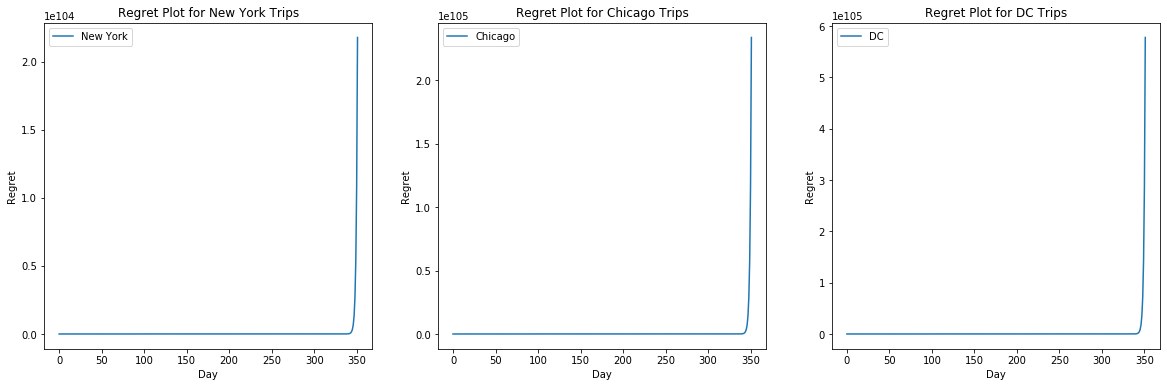

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
sns.lineplot(x=np.arange(352), y= regret_ny, label = 'New York', ax=ax1)
sns.lineplot(x=np.arange(352), y= regret_chi, label = 'Chicago', ax=ax2)
sns.lineplot(x=np.arange(352), y= regret_dc, label = 'DC', ax=ax3)

ax1.set_xlabel('Day')
ax2.set_xlabel('Day')
ax3.set_xlabel('Day')
ax1.set_ylabel('Regret')
ax2.set_ylabel('Regret')
ax3.set_ylabel('Regret')
ax1.set_title('Regret Plot for New York Trips')
ax2.set_title('Regret Plot for Chicago Trips')
ax3.set_title('Regret Plot for DC Trips')

*Note: Regret is scaled by log.

Text(0.5, 1.0, 'Number of Pulls for DC Trips')

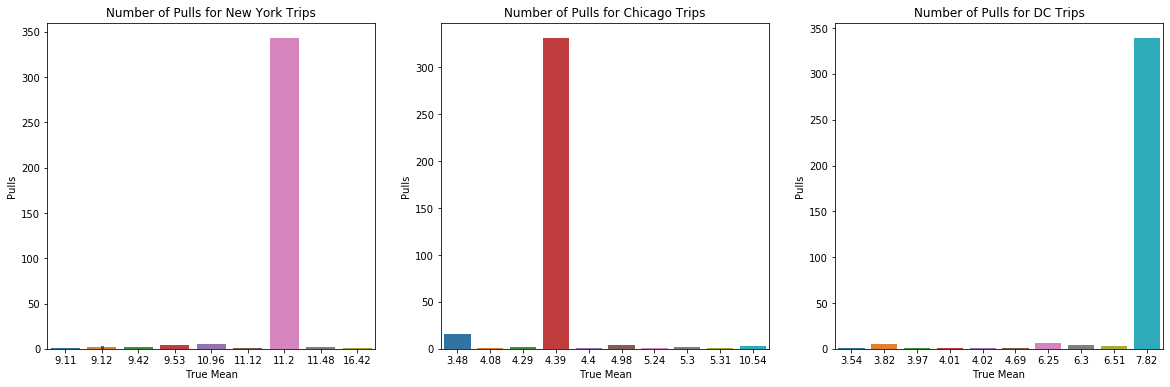

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
sns.barplot(np.round(ny_means, 2), list(T_ny.values()), label='New York', ax=ax1)
sns.barplot(np.round(chi_means,2), list(T_chi.values()), label='Chicago',ax=ax2)
sns.barplot(np.round(dc_means, 2), list(T_dc.values()), label='DC', ax=ax3)

ax1.set_xlabel('True Mean')
ax2.set_xlabel('True Mean')
ax3.set_xlabel('True Mean')
ax1.set_ylabel('Pulls')
ax2.set_ylabel('Pulls')
ax3.set_ylabel('Pulls')
ax1.set_title('Number of Pulls for New York Trips')
ax2.set_title('Number of Pulls for Chicago Trips')
ax3.set_title('Number of Pulls for DC Trips')

Text(0.5, 1.0, 'Estimated mean of UCBs for DC Trips')

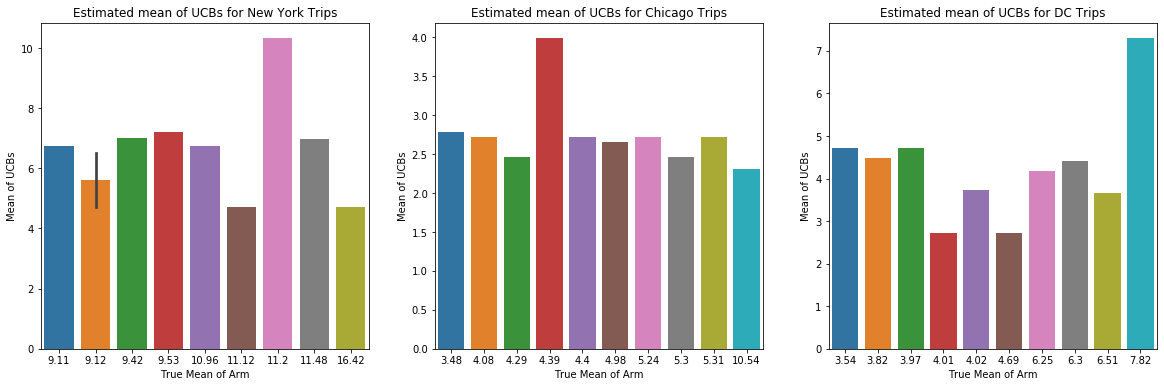

In [17]:
ucb_ny_means = [np.mean(ucb_ny[key]) for key in ucb_ny.keys()]
ucb_chi_means = [np.mean(ucb_chi[key]) for key in ucb_chi.keys()]
ucb_dc_means = [np.mean(ucb_dc[key]) for key in ucb_dc.keys()]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
sns.barplot(np.round(ny_means, 2), ucb_ny_means, label='New York', ax=ax1)
sns.barplot(np.round(chi_means,2), ucb_chi_means, label='Chicago',ax=ax2)
sns.barplot(np.round(dc_means, 2), ucb_dc_means, label='DC', ax=ax3)

ax1.set_xlabel('True Mean of Arm')
ax2.set_xlabel('True Mean of Arm')
ax3.set_xlabel('True Mean of Arm')
ax1.set_ylabel('Mean of UCBs')
ax2.set_ylabel('Mean of UCBs')
ax3.set_ylabel('Mean of UCBs')
ax1.set_title('Estimated mean of UCBs for New York Trips')
ax2.set_title('Estimated mean of UCBs for Chicago Trips')
ax3.set_title('Estimated mean of UCBs for DC Trips')


Text(0.5, 1.0, 'Estimated Mean of Rewards for DC Trips')

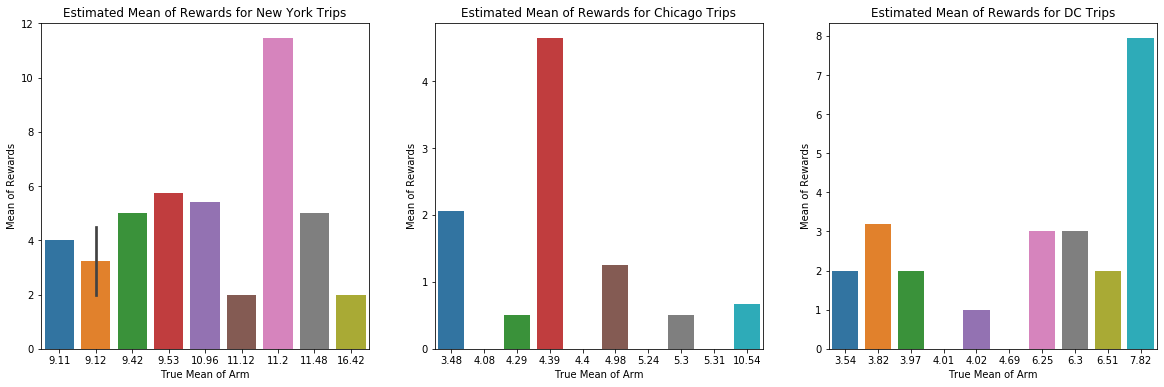

In [18]:
rwd_ny_means = [np.mean(rewards_ny[key]) for key in rewards_ny.keys()]
rwd_chi_means = [np.mean(rewards_chi[key]) for key in rewards_chi.keys()]
rwd_dc_means = [np.mean(rewards_dc[key]) for key in rewards_dc.keys()]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
sns.barplot(np.round(ny_means, 2), np.round(rwd_ny_means, 2), label='New York', ax=ax1)
sns.barplot(np.round(chi_means, 2), np.round(rwd_chi_means,2), label='Chicago',ax=ax2)
sns.barplot(np.round(dc_means, 2), np.round(rwd_dc_means, 2), label='DC', ax=ax3)

ax1.set_xlabel('True Mean of Arm')
ax2.set_xlabel('True Mean of Arm')
ax3.set_xlabel('True Mean of Arm')
ax1.set_ylabel('Mean of Rewards')
ax2.set_ylabel('Mean of Rewards')
ax3.set_ylabel('Mean of Rewards')
ax1.set_title('Estimated Mean of Rewards for New York Trips')
ax2.set_title('Estimated Mean of Rewards for Chicago Trips')
ax3.set_title('Estimated Mean of Rewards for DC Trips')

### 1.2.2 Discussion

The results of my simulation will change depending on which arms are pulled first because the values of T and the mean of rewards will change. However, the order should be random because the user should not know what the distributions of each arm looks like.

An adaptive strategy that could beat the no-regret strategy would be to first explore each intersection once and then from there, choose the one with the highest reward and send the recruiter to that intersection every day.

## 1.3 Takeaways

The applicablity to the problem I presented in section 1.1 is valid because in the UCB simulation, I was able to find the intersection that was exploited after exploration. Therefore, from that, I would have an idea of where to send the recruiter to give out the most flyers to. However, the simulation is lacking in the sense that the alorgithm's definition of reward is different. The simulation takes riders as rewards, but my problem takes flyers as rewards, so that is an example where the simulation is lacking. 

There is a violation of assumption in the simulation where we take the observations as our sample, which is not randomly generated. The rewards should be randomly generated at each intersection where the recruiter will be able to explore and not use past observations. In addition, this shows that the rewards for each arm is not independent.

I would not recommend using the UCB alorigthm to place a recruiter to hand out flyers. Instead, I would use Thompson sampling where the probability that an intersection is optimal is given. From there, we will be able to choose the intersection with the highest probability and place the recruiter there to hand out flyers to promote the company. To support this recommendation, I would approximate the posterior distributions using methods like Gibbs sampling, Laplace approximate, and bootstraps, which we didn't do in the simulation.

# 2 Privacy Concerns

In [19]:
url_leaked = 'https://raw.githubusercontent.com/ds-102/fa19/master/project/leaked.csv'
url_berk = 'https://raw.githubusercontent.com/ds-102/fa19/master/project/berkeley.csv'
leaked = pd.read_csv(url_leaked, error_bad_lines=False)
berk = pd.read_csv(url_berk, error_bad_lines=False)

In [20]:
leaked.head()

,name,sex,zip,month,year
0,Avery Phillips,M,94709,3,1993
1,Grayson Rodriguez,M,94705,6,1998
2,Ethan Baker,M,94712,1,1998
3,Carter Wright,M,94720,7,1995
4,Elijah Young,M,94706,2,1996


In [21]:
berk.head()

,sex,month,year,start,end
0,M,12,1999,94704,94704
1,M,12,2000,94706,94706
2,M,4,1999,94703,94703
3,M,2,1999,94710,94710
4,M,12,1994,94707,94707


Text(0.5, 1.0, 'Gender Distribution in Leaked Dataset')

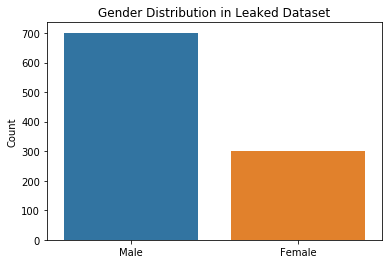

In [22]:
males = len(leaked[leaked['sex']=='M'])
females = len(leaked[leaked['sex']=='F'])
sns.barplot(['Male', 'Female'], [males, females])
plt.ylabel('Count')
plt.title('Gender Distribution in Leaked Dataset')

Text(0.5, 1.0, 'Birth Month Distribution')

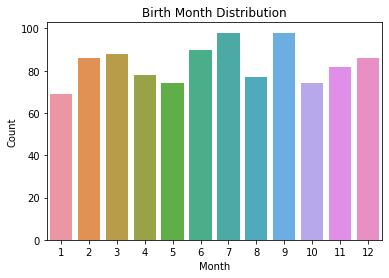

In [23]:
months = leaked.groupby('month').count().iloc[:, 0].values
sns.barplot(np.arange(1, 13), months)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Birth Month Distribution')

Text(0.5, 1.0, 'Birth Year Distribution')

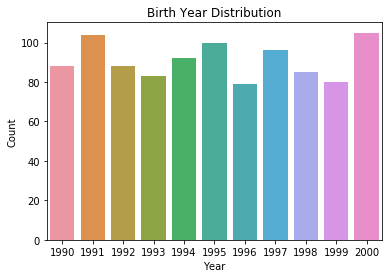

In [24]:
yrs = leaked.groupby('year').count().iloc[:, 0].values
sns.barplot(np.sort(leaked['year'].unique()), yrs)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Birth Year Distribution')

### Description for distribution similaries/differences to part 1

For the most part, the distributions of birth months and years are uniformly distributed, but are not similar to the distribution in part 1, which had a significant peak from the rest. However, the gender ratio is not uniform, but is similar to the distribtion in part 1. 

## 2.2 Simple Proof of Concept

In [25]:
def unique_index(df, sex, month, year):
    df = df[(df['sex']==sex) & (df['month']==month) & (df['year']==year)]
    return df.index.values[0]

In [26]:
def unique_df(df, sex, month, year):
    df = df[(df['sex']==sex) & (df['month']==month) & (df['year']==year)]
    if len(df) == 1:
        return True
    else:
        return False

In [27]:
rows = []
for s in ['M', 'F']:
    for m in np.arange(1,13):
        for y in np.arange(1990, 2001):
            if unique_df(leaked, s, m, y):
                rows.append(unique_index(leaked, s, m, y))

In [28]:
iden_users = leaked.iloc[rows, :]
print('We can unique identify', len(iden_users), 'users.')

We can unique identify 43 users.


Text(0.5, 1.0, 'Gender Distribution of Identifiable Users Dataset')

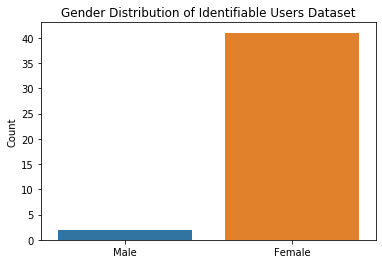

In [29]:
iden_males = len(iden_users[iden_users['sex']=='M'])
iden_females = len(iden_users[iden_users['sex']=='F'])
sns.barplot(['Male', 'Female'], [iden_males, iden_females])
plt.ylabel('Count')
plt.title('Gender Distribution of Identifiable Users Dataset')

### Description

The gender distribution of identifiable users is predominantly female; this is opposite of what we saw in 2.1, which was predominantly male. There are more females that are identifiable users based on birth month, year, and gender because our original dataset had more males, which lowers the probability of a male having a unique birth month and year from the rest.

Text(0.5, 1.0, 'Birth Month Distribution in Identifiable Users Dataset')

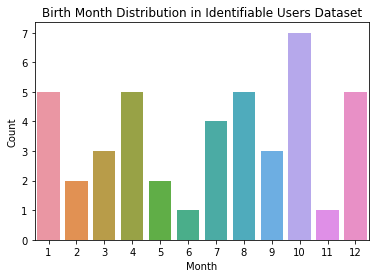

In [30]:
months = iden_users.groupby('month').count().iloc[:, 0].values
sns.barplot(np.arange(1, 13), months)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Birth Month Distribution in Identifiable Users Dataset')

The birth month distribution in the identifiable users dataset is not uniform and does not match the distribution in the original dataset. The reason is because a birth month will only appear in the new dataset if it is a unique row based on gender and birth year.

In [31]:
def script(df, df1):
    merged_df = pd.merge(df, df1, on=['sex', 'month', 'year'], how='outer').dropna()
    grouped = merged_df.groupby('name').count()
    return grouped[['sex']].rename(columns={'sex': 'num_rentals'})
grouped_df = script(berk, iden_users)
grouped_df.head()

,num_rentals
name,
Abigail Campbell,90
Abigail Carter,79
Abigail King,15
Amelia Clark,62
Amelia Lopez,69


### Description of Script

This script takes 2 dataframes, the scooter rental and identifiable users dataset, and returns a dataframe with names and their number of rentals. It does so by using an outer join on the sex, month, and year column, grouping by name, and aggregating by the count.

## 2.3 A More Elaborate Attack

In [32]:
merged_df = pd.merge(berk, iden_users, on=['sex', 'month', 'year'], how='outer').dropna()
merged_df['zip'] = merged_df['zip'].astype(int).values
start = merged_df[merged_df['start'] != merged_df['zip']]
end = merged_df[merged_df['end'] != merged_df['zip']]

start = start.groupby('name').count()
start = start[['sex']].rename(columns={'sex': 'num_rentals'})
end = end.groupby('name').count()
end = end[['sex']].rename(columns={'sex': 'num_rentals'})

x1 = start['num_rentals'].values
x2 = end['num_rentals'].values

In [33]:
p1 = np.sum(x1) / len(merged_df)
p2 = np.sum(x2) / len(merged_df)
print('Estimated proportion of users who start their trip from a different zip code: ', np.round(p1,3))
print('Estimated proportion of users who start their trip from a different zip code: ', np.round(p2,3))

Estimated proportion of users who start their trip from a different zip code:  0.097
Estimated proportion of users who start their trip from a different zip code:  0.278


### Description of Parameter Estimation

For p1, I took the number of trips that started in a different zip code from a user's address zip code over all trips.
For p2, I did the same thing, but for the number of trips that ended in a different zip code.

In [34]:
p1_lower, p1_upper = proportion_confint(np.sum(x1), len(merged_df), alpha=0.05, method='normal')
p2_lower, p2_upper = proportion_confint(np.sum(x2), len(merged_df), alpha=0.05, method='normal')

In [35]:
print('95% Confidence Interval for P1: ', (p1_lower, p1_upper))
print('95% Confidence Interval for P2: ', (p2_lower, p2_upper))

95% Confidence Interval for P1:  (0.08426845228803953, 0.1089288266235251)
95% Confidence Interval for P2:  (0.2593047348191409, 0.29670433547564373)


### Description of Confidence Interval Method

Using the proportion_confint function from the statsmodels library, I generated the 95% confidence intervals by inputting my proportion estimates and alpha level 0.05.

In [36]:
leaked['zip'].unique()

array([94709, 94705, 94712, 94720, 94706, 94708, 94704, 94702, 94701,
       94707, 94710, 94703])

In [37]:
def unique_index_1(df, z, sex, month, year):
    df = df[(df['sex']==sex) & (df['month']==month) & (df['year']==year) & (df['zip']==z)]
    return df.index.values[0]
def unique_df_1(df, z, sex, month, year):
    df = df[(df['sex']==sex) & (df['month']==month) & (df['year']==year) & (df['zip']==z)]
    if len(df) == 1:
        return True
    else:
        return False

In [38]:
rows = []
for s in ['M', 'F']:
    for m in np.arange(1,13):
        for y in np.arange(1990, 2001):
            for z in leaked['zip'].unique():
                if unique_df_1(leaked, z, s, m, y):
                    rows.append(unique_index_1(leaked, z, s, m, y))
t_iden_users = leaked.iloc[rows, :]

In [39]:
print('There are', len(t_iden_users), 'theoretically identifiable users.')

There are 720 theoretically identifiable users.


In [40]:
df = pd.merge(berk, t_iden_users, on=['sex', 'month', 'year'], how='outer').dropna()

In [41]:
df.head()

,sex,month,year,start,end,name,zip
0,M,12,1999,94704,94704,Aiden Miller,94712.0
1,M,12,1999,94704,94704,Joseph Williams,94704.0
2,M,12,1999,94704,94704,Dylan Harris,94707.0
3,M,12,1999,94709,94704,Aiden Miller,94712.0
4,M,12,1999,94709,94704,Joseph Williams,94704.0


In [42]:
grouped_trips = df.groupby(['sex', 'month', 'year', 'start', 'end']).aggregate(lambda tdf: tdf.unique().tolist())


In [43]:
def find_user_by_trip(sex, month, year, start, end):
    row = grouped_trips.loc[[(sex, month, year, start, end)]]
    if len(row['name'].values[0]) == 1:
        return row['name'].values[0][0]
    else:
        return random.choice(row['name'].values[0])

In [44]:
find_user_by_trip('M', 12, 2000, 94706, 94704)

'Jacob Harris'

### Description of Algorithm

Before my algorithm, I grouped the trips since there are multiple trips with the same features. This grouped dataframe will have the names of the most likely users in a list. My find most likely user function takes in the specified trip features, finds the row from the grouped dataframe, and return the most likely user. If there are multiple users, it randomly returns one of the users using python's random choice function.

## 2.4 Takeaways

I found that for a dataset, for a given column, the value with a smaller proportion will have a higher proportion in an identifiable dataset, as observed in the gender distribution plots. For uniform distributions in the dataset, the distribution is most likely not going to be uniform from the identifiable dataset. Lastly, I found that the more features there are in a dataset, the more users you can identify from that dataset.

For the already released dataset, I would randomly shuffle the gender column to slightly confuse the result of identifying a user. This would still keep the proportions the same if we were interested in looking at the distribution.

For future datasets, I would recommend the company to achieve k-anonyminity, meaning for a trip in the dataset, make sure that is there at least k users who can be identified from that trip. In the released dataset, there are many trips that match to one user, making it easy to be identified.